In [34]:
from maze2 import Maze, plot_policy, test_agent
import numpy as np
import matplotlib.pyplot as plt
import gym
import random
from tqdm import tqdm
import torch


In [5]:
def seed_everything(env: gym.Env, seed: int = 42)->None:
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

In [6]:
def plot_tabular_cost_to_go(action_vales, xlabel, ylabel):
    plt.figure(figsize = (8,8))
    cost_to_go = -action_vales.max(axis = -1)
    plt.imshow(cost_to_go, cmap='jet')
    plt.title('Estimated cost-to-go',size = 24)
    plt.xlabel(xlabel, size = 18)
    plt.ylabel(ylabel, size = 18)
    plt.xticks([])
    plt.yticks([])
    plt.xticks()
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [7]:
def plot_stats(stats):
    rows = len(stats)
    cols = 1
    fig, ax = plt.subplots(rows, cols, figsize = (12, 6))
    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
        plt.tight_layout()
        plt.show()

In [8]:
# create environment
env = gym.make('MountainCar-v0')
seed_everything(env)

In [9]:
#state aggregation wrapper -> convert continuous state into dicrete state
class StateAggregationEnv(gym.ObservationWrapper):
    def __init__(self, env, bins, low, high):
        super().__init__(env)
        self.buckets = [np.linspace(j, k, l-1) for j,k,l in zip(low, high, bins)]
        self.observation_space = gym.spaces.MultiDiscrete(nvec = bins.tolist())

    def observation(self, obs):
        indices = tuple(np.digitize(i, b) for i,b in zip(obs, self.buckets))
        return indices

In [10]:
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
saenv = StateAggregationEnv(env, bins = bins, low = low, high = high)

In [11]:
saenv.buckets

[array([-1.20000005, -1.10000004, -1.00000004, -0.90000004, -0.80000003,
        -0.70000003, -0.60000002, -0.50000002, -0.40000002, -0.30000001,
        -0.20000001, -0.1       ,  0.        ,  0.1       ,  0.20000001,
         0.30000001,  0.40000002,  0.50000002,  0.60000002]),
 array([-0.07      , -0.06222222, -0.05444444, -0.04666667, -0.03888889,
        -0.03111111, -0.02333333, -0.01555556, -0.00777778,  0.        ,
         0.00777778,  0.01555556,  0.02333333,  0.03111111,  0.03888889,
         0.04666667,  0.05444444,  0.06222222,  0.07      ])]

In [12]:
#compare aggregation states  with original environment
print(f'Modified observation space: {saenv.observation_space}\n Sample state: {saenv.observation_space.sample()}')
print(f'Original Obsevation space: {env.observation_space},\n Sample State: {env.observation_space.sample()}')

Modified observation space: MultiDiscrete([20 20])
 Sample state: [ 5 13]
Original Obsevation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32),
 Sample State: [ 0.1931209  -0.00855702]


In [13]:
action_values = np.zeros((20,20,3))

In [14]:
def policy(state, epsilon = 0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

In [15]:
#sarsa algorithm
def sarsa(action_values, policy, episodes, alpha = 0.1, gamma = 0.99, epsilon = 0.2):
    stats = {'Returns':[]}
    for episode in tqdm(range(1, episodes+1)):
        state = saenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = saenv.step(action)
            next_action = policy(next_state, epsilon)
            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action]
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state = next_state
            action = next_action
            ep_return += reward 
        stats['Returns'].append(ep_return)
    return stats

In [16]:
stats = sarsa(action_values, policy, 20000, alpha = 0.1, epsilon = 0.)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [02:43<00:00, 122.53it/s]


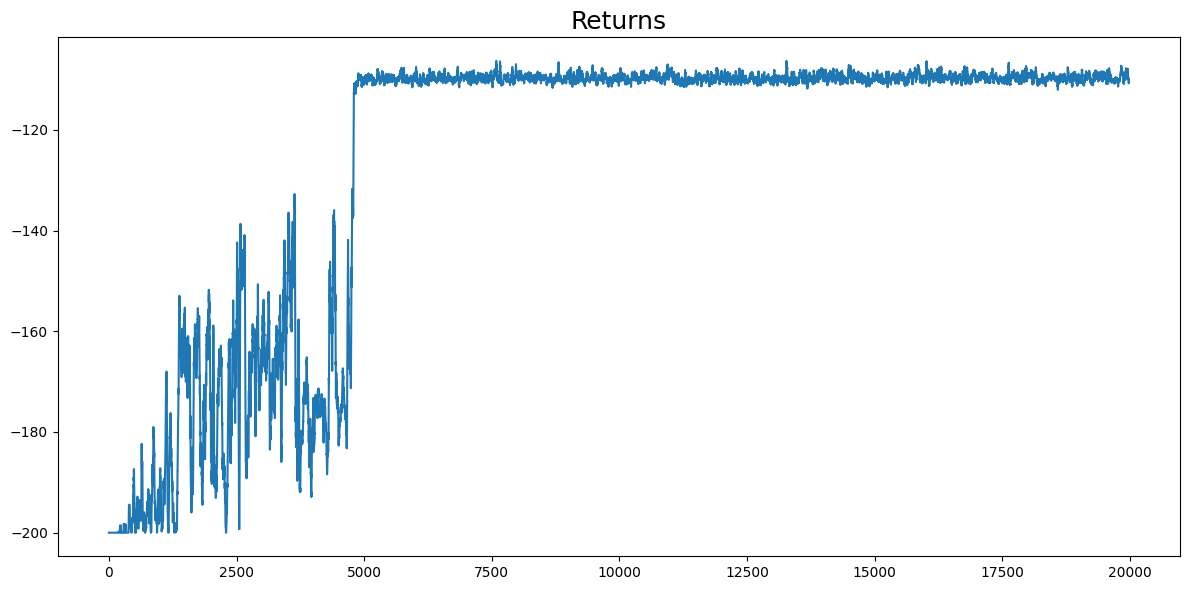

In [17]:
plot_stats(stats)

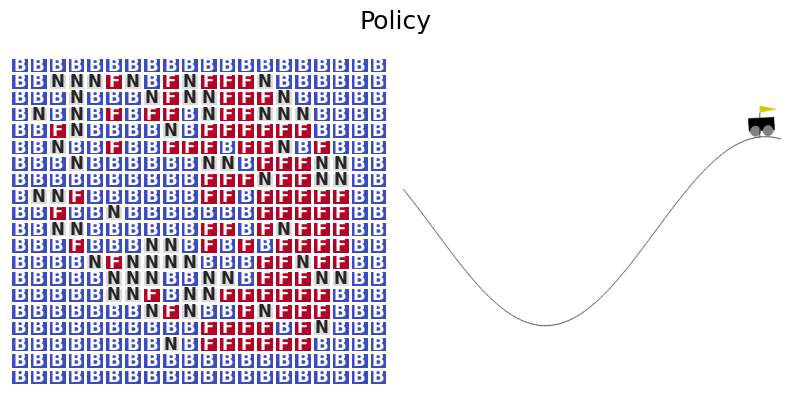

In [18]:
plot_policy(action_values, env.render(mode = 'rgb_array'), action_meanings = {0: 'B',1: 'N',2: 'F'})

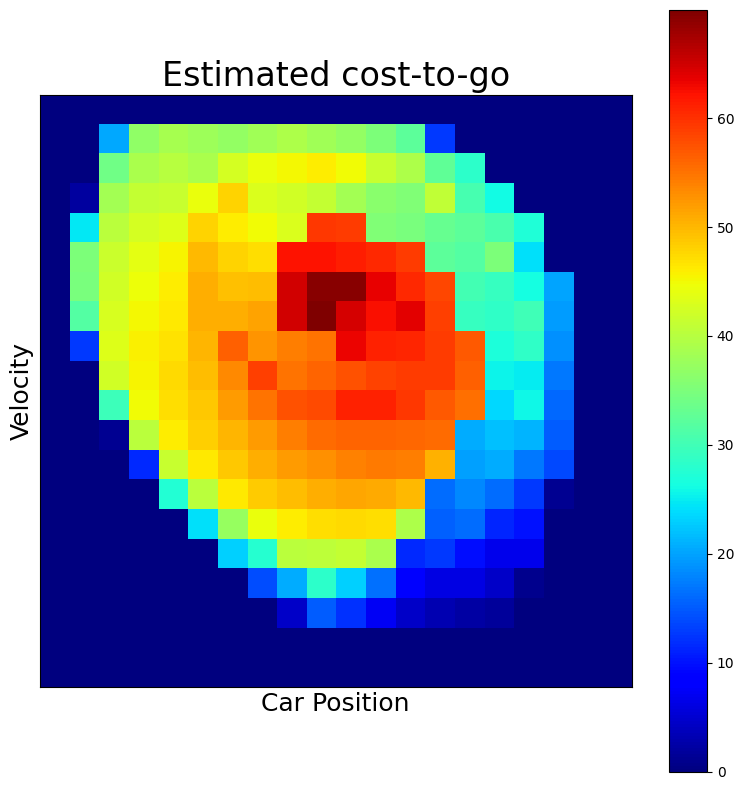

In [19]:
plot_tabular_cost_to_go(action_values, xlabel = 'Car Position', ylabel = 'Velocity')

In [35]:
test_agent(saenv, policy, 2)